#### [학습에 필요한 모듈 선언]

In [1]:
import tensorflow as tf
import pandas as pd
from sklearn.utils import shuffle
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import os
# requests import error 발생시  pip install requests 로 설치
import requests

from datetime import datetime

#### [환경설정]

In [2]:
# 학습 데이터(훈련/테스트) 비율
trainDataRate = 0.7
# 학습률
learningRate = 0.01
# 총 학습 횟수
totalStep = 10001
# 데이터 섞기
shuffleOn = True
# 학습 데이터 파일명 지정
fileName = "IrisData.csv"
# 학습 데이터 경로 지정
currentFolderPath = os.getcwd()
dataSetFolderPath = os.path.join(currentFolderPath, 'dataset')
datasetFilePath = os.path.join(dataSetFolderPath, fileName)

# [Saver] 저장된 모델 파일 지정

In [3]:
# 저장된 모델의 마지막 체크포인트 경로
# latest_checkpoint('모델이 저장된 폴더 경로')
save_file = tf.train.latest_checkpoint('./model/')
print("Last Checkpoint model path : ",save_file)

Last Checkpoint model path :  ./model/model_20190703_154851.ckpt-10000


#### [빌드단계] Step 1) 학습 데이터 준비

> 'dataset' folder is exist.
===== Data =====>
     sepalLength  sepalWidth  petalLength  petalWidth          species
144          6.7         3.3          5.7         2.5   Iris-virginica
146          6.3         2.5          5.0         1.9   Iris-virginica
79           5.7         2.6          3.5         1.0  Iris-versicolor
61           5.9         3.0          4.2         1.5  Iris-versicolor
37           4.9         3.1          1.5         0.1      Iris-setosa
     sepalLength  sepalWidth  petalLength  petalWidth          species
58           6.6         2.9          4.6         1.3  Iris-versicolor
129          7.2         3.0          5.8         1.6   Iris-virginica
133          6.3         2.8          5.1         1.5   Iris-virginica
20           5.4         3.4          1.7         0.2      Iris-setosa
73           6.1         2.8          4.7         1.2  Iris-versicolor
Shape : (150, 5)
Specis : 
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: sp

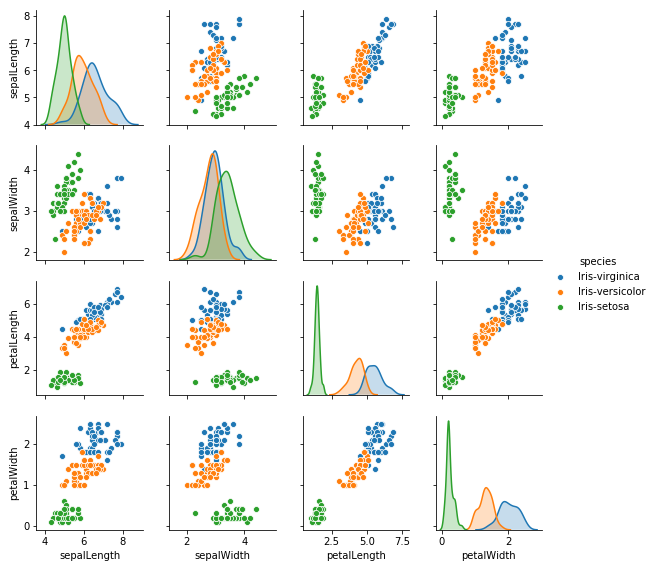

In [4]:
# 데이터셋 저장할 폴더 존재 유무 확인
if os.path.exists(dataSetFolderPath):
    print("> 'dataset' folder is exist.")
else:
    print("> 'dataset' folder is not exist, Create 'dataset' folder.")
    os.mkdir('dataset')

### (1) 데이터 읽어오기
# 해당 경로에 학습 데이터가 없으면 다운로드
if os.path.exists(datasetFilePath) is not True:
    print("#===== Download Iris Data =====#")
    # iris 데이터 셋 다운로드
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
    req = requests.get(url, allow_redirects = True)
    # 학습데이터 저장
    open(datasetFilePath, "wb").write(req.content)
    print("#===== Download Completed =====#")

# pandas를 이용하여 CSV 파일 데이터 읽기
allColumnName = ["sepalLength","sepalWidth","petalLength","petalWidth","species"]

# column이 없는 데이터라서 파일을 읽어올때 header 를 생성하지 않고 column을 추가
if shuffleOn :
    df = shuffle(pd.read_csv(datasetFilePath, header = None, names = allColumnName))
else :
    df = pd.read_csv(datasetFilePath, header = None, names = allColumnName)


# 학습 데이터 확인
print("===== Data =====>")
print(df.head())
print(df.tail())
# 학습 데이터 shape 확인
print("Shape : {}".format(df.shape))
# 학습 데이터 결과 갯수 확인
print("Specis : \n{}".format(df["species"].value_counts()))


# 학습 데이터 전체 그래프
sns.pairplot(df, hue="species", height = 2)
plt.show()


In [5]:
### (2) 범주형 데이터 맴핑 선언
# species 를 3가지 종류로 나눈 dataframe 으로 변환
df_one_hot_encoded = pd.get_dummies(df)

print("===== after mapping =====>")
print(df_one_hot_encoded.head())
print(df_one_hot_encoded.tail())

===== after mapping =====>
     sepalLength  sepalWidth  petalLength  petalWidth  species_Iris-setosa  \
144          6.7         3.3          5.7         2.5                    0   
146          6.3         2.5          5.0         1.9                    0   
79           5.7         2.6          3.5         1.0                    0   
61           5.9         3.0          4.2         1.5                    0   
37           4.9         3.1          1.5         0.1                    1   

     species_Iris-versicolor  species_Iris-virginica  
144                        0                       1  
146                        0                       1  
79                         1                       0  
61                         1                       0  
37                         0                       0  
     sepalLength  sepalWidth  petalLength  petalWidth  species_Iris-setosa  \
58           6.6         2.9          4.6         1.3                    0   
129          7.2  

In [6]:
### (3) 훈련, 테스트 데이터 나누기
# 학습 데이터 리스트로 변환
# 훈련 데이터를 정해진 비율만큼 추출
df_trainData = df_one_hot_encoded.sample(frac = trainDataRate)

# 훈련 데이터를 제거한 나머지 데이터를 테스트 테이터로 지정
df_testData = df_one_hot_encoded.drop(df_trainData.index)

# 학습데이터와 결과데이터의 컬럼 선언
featureColumnName = ["sepalLength","sepalWidth","petalLength","petalWidth"]
resultColumnName = ['species_Iris-setosa','species_Iris-versicolor','species_Iris-virginica']
# 학습데이터 선언
xTrainDataList = df_trainData.filter(featureColumnName)
yTrainDataList = df_trainData.filter(resultColumnName)
# 테스트 데이터 선언
xTestDataList = df_testData.filter(featureColumnName)
yTestDataList = df_testData.filter(resultColumnName)

print("[TrainData Size] x : {}, y :{}".format(len(xTrainDataList),len(yTrainDataList)))
print("[TestData Size] x : {}, y :{}".format(len(xTestDataList),len(yTestDataList)))

[TrainData Size] x : 105, y :105
[TestData Size] x : 45, y :45


#### [빌드단계] Step 2) 모델 생성을 위한 변수 초기화

In [7]:
# feature 로 사용할 데이터 갯수
feature_num = len(featureColumnName)
# result 로 사용할 종류 갯수
result_num = len(resultColumnName)

# 학습데이터가 들어갈 플레이스 홀더 선언
X = tf.placeholder(tf.float32, shape = [None, feature_num], name='X')
# 학습데이터가 들어갈 플레이스 홀더 선언
Y = tf.placeholder(tf.float32, shape = [None, result_num], name='Y')


# Weight 변수 선언
W = tf.Variable(tf.zeros([feature_num, result_num]), name='Weight')
# Bias 변수 선언
b = tf.Variable(tf.zeros([result_num]), name='bias')

# [Saver] saver 객체 생성

In [8]:
 saver = tf.train.Saver()

#### [빌드단계] 3) 학습 모델 그래프 구성

In [9]:
# 3-1) 학습데이터를 대표 하는 가설 그래프 선언
hypothesis = tf.nn.softmax(logits= tf.matmul(X, W) + b, name='hypothesis')

# 3-2) 비용함수(오차함수,손실함수) 선언
costFunction = tf.reduce_mean(-tf.reduce_sum(Y * tf.log(hypothesis), axis=1), name='costFunction')

# 3-3) 비용함수의 값이 최소가 되도록 하는 최적화함수 선언
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learningRate)
train = optimizer.minimize(costFunction)

#### [실행단계] 학습 모델 그래프를 실행

In [10]:
# 실행을 위한 세션 선언
sess = tf.Session()

In [11]:
# 예측값, 정확도 수식 선언
predicted = tf.equal(tf.argmax(hypothesis, axis = 1), tf.argmax(Y, axis =1))
accuracy = tf.reduce_mean(tf.cast(predicted, tf.float32))

# [Saver] 저장된 모델 불러오기

In [12]:
saver.restore(sess, save_file)

INFO:tensorflow:Restoring parameters from ./model/model_20190703_154851.ckpt-10000


# [Saver] 저장된 모델을 이용하여 테스트 결과 출력

In [13]:
print("--------------------------------------------------------------------------------")
print("[Test Result]")
# 최적화가 끝난 학습 모델 테스트
h_val, p_val, a_val = sess.run([hypothesis, predicted, accuracy],
                    feed_dict={X: xTestDataList, Y: yTestDataList})
print("\nHypothesis : {} \nPrediction : {} \nAccuracy : {}".format(h_val,p_val,a_val))
print("--------------------------------------------------------------------------------")

--------------------------------------------------------------------------------
[Test Result]

Hypothesis : [[1.37288471e-05 2.84994040e-02 9.71486807e-01]
 [9.73511457e-01 2.64885873e-02 4.85861449e-08]
 [9.77235258e-01 2.27645934e-02 1.11674275e-07]
 [9.92023468e-01 7.97649287e-03 4.72927386e-09]
 [9.19811555e-06 7.40865692e-02 9.25904214e-01]
 [8.55159396e-06 1.00909211e-01 8.99082243e-01]
 [2.88899685e-03 7.68131554e-01 2.28979439e-01]
 [1.58321559e-02 9.25406098e-01 5.87618351e-02]
 [9.92028058e-01 7.97196291e-03 8.34471425e-09]
 [1.28992395e-02 9.00008142e-01 8.70925635e-02]
 [7.28977285e-03 8.42654765e-01 1.50055438e-01]
 [1.50696479e-03 6.76406741e-01 3.22086304e-01]
 [1.09111378e-02 8.86352181e-01 1.02736734e-01]
 [9.87275898e-01 1.27240736e-02 3.59808290e-08]
 [9.93721247e-01 6.27877424e-03 3.85787091e-09]
 [8.29145254e-04 3.92702341e-01 6.06468499e-01]
 [1.07986991e-04 1.73310742e-01 8.26581299e-01]
 [9.82717216e-01 1.72826890e-02 8.79787336e-08]
 [2.35269094e-04 2.12405309

# [Saver] 저장된 모델을 이용하여 재학습

In [14]:
# 학습, 테스트 정확도를 저장할 리스트 선언
train_accuracy = list()

--------------------------------------------------------------------------------
Train(Optimization) Start 
step : 0. cost : 0.12118100374937057, accuracy : 0.9809523820877075
step : 1000. cost : 0.11522280424833298, accuracy : 0.9809523820877075
step : 2000. cost : 0.11029304563999176, accuracy : 0.9904761910438538
step : 3000. cost : 0.10607223212718964, accuracy : 0.9809523820877075
step : 4000. cost : 0.10241061449050903, accuracy : 0.9809523820877075
step : 5000. cost : 0.09919911623001099, accuracy : 0.9809523820877075
step : 6000. cost : 0.09635621309280396, accuracy : 0.9809523820877075
step : 7000. cost : 0.09381939470767975, accuracy : 0.9809523820877075
step : 8000. cost : 0.0915399119257927, accuracy : 0.9809523820877075
step : 9000. cost : 0.08947918564081192, accuracy : 0.9809523820877075
step : 10000. cost : 0.08760607242584229, accuracy : 0.9809523820877075
W : [[ 1.1375867   0.7574338  -1.8949943 ]
 [ 2.4863966   0.01896844 -2.5053277 ]
 [-3.4349597  -0.08515339  3.519

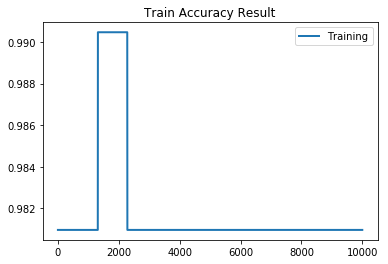

Train Finished
--------------------------------------------------------------------------------


In [15]:
print("--------------------------------------------------------------------------------")
print("Train(Optimization) Start ")

for step in range(totalStep):
    # X, Y에 학습데이터 입력하여 비용함수, W, b, accuracy, train을 실행
    cost_val, W_val, b_val, acc_val, _ = sess.run([costFunction, W, b, accuracy, train],
                                            feed_dict = {X: xTrainDataList, Y: yTrainDataList})
    train_accuracy.append(acc_val)

    if step % 1000 == 0:
        print("step : {}. cost : {}, accuracy : {}".format(step, cost_val, acc_val))
        
    if step == totalStep-1 :
        print("W : {}\nb:{}".format(W_val, b_val))
    


# matplotlib 를 이용하여 결과를 시각화
# 정확도 결과 확인 그래프
plt.plot(range(len(train_accuracy)), train_accuracy, linewidth = 2, label = 'Training')
plt.legend()
plt.title("Train Accuracy Result")
plt.show()


print("Train Finished")
print("--------------------------------------------------------------------------------")